 使用Opencv将图片中的人脸部分框取出来
 并且处理成相同大小的图片

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import numpy as np

# 设置训练集和测试集图片像素的同一大小
pixel = 150

def getImg(path):
    img = cv2.imread(path)
    # 将测试图像转换为灰度图像，因为opencv人脸检测器需要灰度图像
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 加载OpenCV人脸检测分类器Haar
    face_cascade = cv2.CascadeClassifier('C:/Users/67418/Desktop/ooo.xml')

    # 检测多尺度图像，返回值是一张脸部区域信息的列表（x,y,宽,高）
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5)
    
    if len(faces) == 0:
        return faces
    # 目前假设只有一张脸，xy为左上角坐标，wh为矩形的宽高
    (x, y, w, h) = faces[0]

    data = cv2.resize(gray[y:y + w, x:x + h], dsize=None, fx=pixel/w, fy=pixel/h, interpolation=cv2.INTER_LINEAR)

    # 返回图像的正面部分
    #print(gray[y:y + w, x:x + h])
    return data

数据前处理
获取人脸照片数大于一定数量的照片
生成训练集和测试集，其中每个人的训练集数量是num，剩下的归到测试集中。

In [2]:
# 设置人脸图片数量大于一定数值才能参与训练
num = 65

# 设置文件的基础路径
basePath = "E:/Downloads/lfw_funneled/"
# 获取基础路径下人名路径
allnames = os.listdir(basePath)
# 初始化训练集和测试集
train = [list(), list()]
test = [list(), list()]
# 初始化标签集
names = list()
lable = 0
for name in allnames:
    k = 0
    imgPaths = os.listdir(basePath + name)
    if len(imgPaths) > num:
        for imgPath in imgPaths:
            img = getImg(basePath + name + "/" + imgPath)
            if len(img) > 0:
                img = img.reshape(-1,)
                if k < num:
                    train[0].append(img)
                    train[1].append(lable)
                else:
                    test[0].append(img)
                    test[1].append(lable)
                k += 1
        names.append(name)
        lable += 1
X_train = train[0]
y_train = train[1]
X_test = test[0]
y_test = test[1]

In [3]:
# PCA降维后的维数
n_components=150
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, pixel, pixel))

#将训练集和测试集的特征点转化到降维后的空间
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

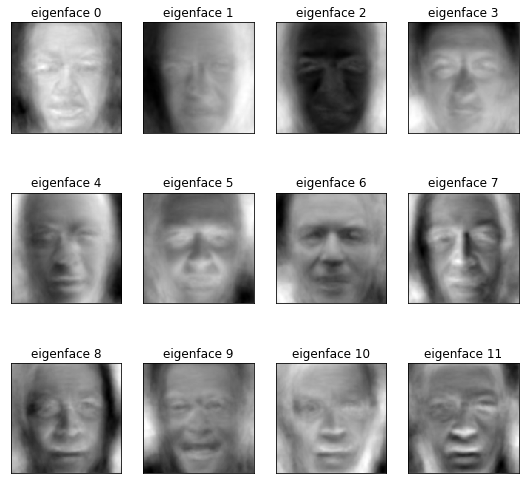

In [4]:
# 帮助画图的函数
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# 画出重要的特征脸
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, 150, 150)

In [5]:
# 设置好网格搜索的参数
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

# 开始训练
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train_pca, y_train)

In [6]:
# 最终结果
y_test = np.array(y_test)
y_pred = clf.predict(X_test_pca)
re = np.arange(0,y_pred.shape[0])
result = re[y_pred == y_test]
print("预测结果个数:",y_pred.shape[0])
print("测试集结果个数:",y_test.shape[0])
print("预测正确的个数：",result.shape[0])
print("最终正确率：",result.shape[0]/y_test.shape[0])
print(clf.best_estimator_)

预测结果个数: 710
测试集结果个数: 710
预测正确的个数： 562
最终正确率： 0.7915492957746478
SVC(C=1000.0, class_weight='balanced', gamma=0.005)


In [7]:
# 生成分类报告
target_names = np.array(names) 
n_classes = target_names.shape[0]

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

                   precision    recall  f1-score   support

     Ariel_Sharon       0.00      0.00      0.00         1
     Colin_Powell       0.86      0.80      0.83       135
  Donald_Rumsfeld       0.59      0.85      0.70        46
    George_W_Bush       0.96      0.79      0.86       425
Gerhard_Schroeder       0.55      0.65      0.59        34
      Hugo_Chavez       0.00      0.00      0.00         0
       Tony_Blair       0.62      0.84      0.71        69

         accuracy                           0.79       710
        macro avg       0.51      0.56      0.53       710
     weighted avg       0.86      0.79      0.82       710

[[  0   0   0   0   1   0   0]
 [  4 108   4   8   1   3   7]
 [  1   1  39   1   2   1   1]
 [ 10  12  21 335  10  12  25]
 [  0   2   1   4  22   2   3]
 [  0   0   0   0   0   0   0]
 [  0   3   1   2   4   1  58]]


C:\Users\67418\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
